In [1]:
import numpy as np
import math
from fractions import Fraction
import itertools
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_object import *
import matplotlib.pyplot as plt
from numpy import array, zeros, ones, arange, log2, sqrt, diff, concatenate
import emd
from PyEMD import EMD, EEMD
from scipy.signal import butter, lfilter
import colorednoise as cn
import pytuning.visualizations.scales
from pytuning.visualizations.scales import consonance_matrix
import csv
import mne
import os
import time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from biotuner.dictionaries import *

pygame 2.0.2 (SDL 2.0.16, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


#### This notebook is intended to demonstrate the use of the biotuner (https://github.com/antoineBellemare/biotuner/)
#### The general idea is to extract harmonic information from biological time series to inform the computation of musical structures
#### The terms ''tuning'' and ''scale'' will be used interchangeably, referring to a series of ratios that subdivide an octave

## Load dataset

In [27]:
data = np.load('data_examples/EEG_pareidolia/parei_data_1000ts.npy')

## peaks_extraction and peaks_extension methods

There is no minimum size for time series. However, time series shorter than 1 second will not allow for peak extraction below 2Hz.

Peaks functions:

'fixed' : ranges of frequency bands are fixed

'adapt' : ranges of frequency bands are defined based on the alpha peak

'EMD': Intrinsic Mode Functions (IMFs) are derived from Empirical Mode Decomposition (EMD)  
                   FFT is computed on each IMF
                   
'EEMD': Intrinsic Mode Functions (IMFs) are derived from Ensemble Empirical Mode Decomposition (EMD)  
                    FFT is computed on each IMF
                    
'HH1D_max': maximum values of the 1d Hilbert-Huang transform on each IMF using EEMD.

'harmonic_peaks': keeps peaks for which a maximum of other peaks are harmonics

'cepstrum': peak frequencies of the cepstrum (inverse Fourier transform (IFT) of the logarithm of the estimated signal spectrum)

'FOOOF' : peaks rising above the aperiodic component

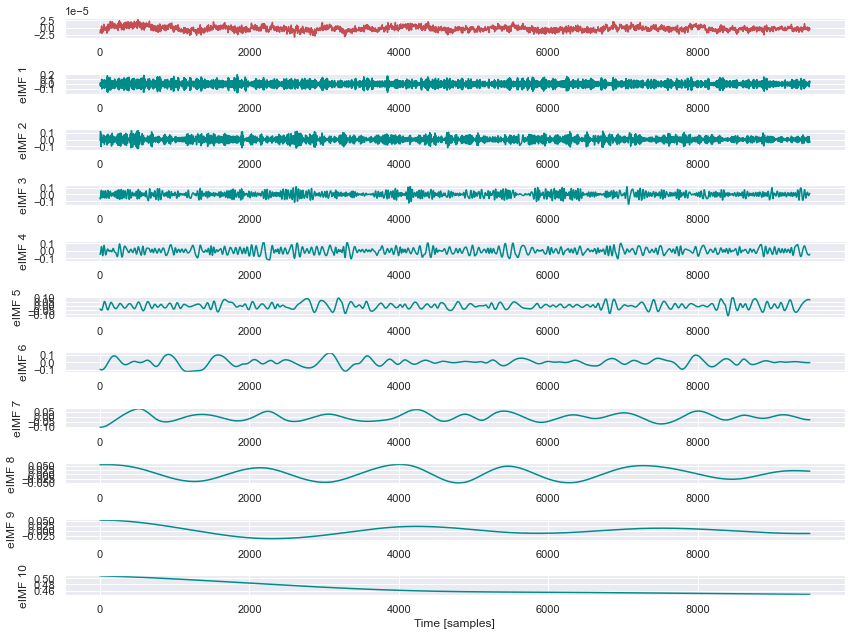

Number of peaks:  5
4.587270736694336


In [16]:
data_ = data[38]
start = time.time()
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 18], [18, 30], [30, 45]] # Define frequency bands for peaks_function = 'fixed'

biotuning = biotuner(sf = 1000, peaks_function = 'EMD', precision = 0.5, n_harm = 20,
                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object

biotuning.peaks_extraction(data_, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 30, n_peaks=5,
                          graph=True, min_harms=2)
biotuning.compute_peaks_metrics()

stop = time.time()
print(stop-start)

In [17]:
biotuning.peaks

array([ 2. ,  5.5, 11.5, 28. , 61. ])

## Dissonance curve

The dissonance curve needs as input a list of peaks and a list of associated amplitudes. Since providing less than 6 spectral peaks would lead to less interesting dissonance curve, the method ''peaks_extension'' provides a way to extend the number of peaks based on the harmonic_fit function (see biotuner.py)

peaks_extension methods: 
['harmonic_fit', 'consonant', 'multi_consonant', 'consonant_harmonic_fit', 'multi_consonant_harmonic_fit']

Number of extended peaks :  7


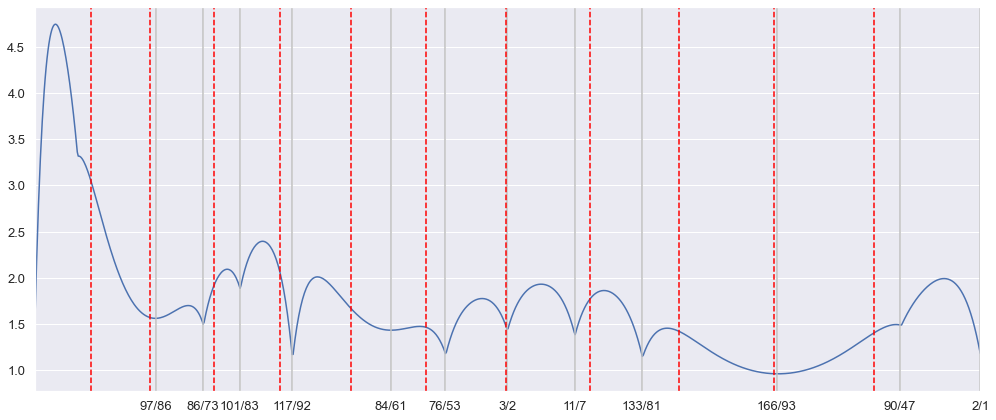

In [22]:
biotuning.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult',  n_harm = 35, cons_limit = 0.05, 
                          ratios_extension = True, scale_cons_limit = 0.1)
biotuning.compute_diss_curve(plot = True, input_type = 'extended_peaks', euler_comp = False, denom = 100, max_ratio = 2, n_tet_grid = 12)


In [9]:
print('Dissonance curve metrics:', biotuning.scale_metrics)
print('Dissonance curve tuning:', biotuning.diss_scale)
print('Dissonance curve consonant tuning:', biotuning.diss_scale_cons)

Dissonance curve metrics: {'diss_euler': 'NaN', 'dissonance': 0.5063975089495999, 'diss_harm_sim': 6.23562296784884, 'diss_n_steps': 8}
Dissonance curve tuning: [1.1919191919191918, 1.2717391304347827, 1.3529411764705883, 1.4444444444444444, 1.6020408163265305, 1.7222222222222223, 1.9550561797752808, 2.0]
Dissonance curve consonant tuning: [1.353 1.444 2.   ]


In [10]:
### If you want the tuning in fraction
scale_frac, num, denom = scale2frac (biotuning.diss_scale, maxdenom = 1000)
scale_frac

[118/99, 117/92, 23/17, 13/9, 157/98, 31/18, 174/89, 2]

## Harmonic entropy

Harmonic entropy takes as input a list of ratios.

If input_type = 'peaks' or 'extended_peaks', their ratios will be used.
Other input types use extended ratios : see biotuner ref.

'extended_ratios_inc'  (increments of the ratios in the form of 'r^1, r^2, r^3, ... r^n)

'extended_ratios_inc_fit' (harmonic fit between the ratios increments)

'extended_ratios_harm'


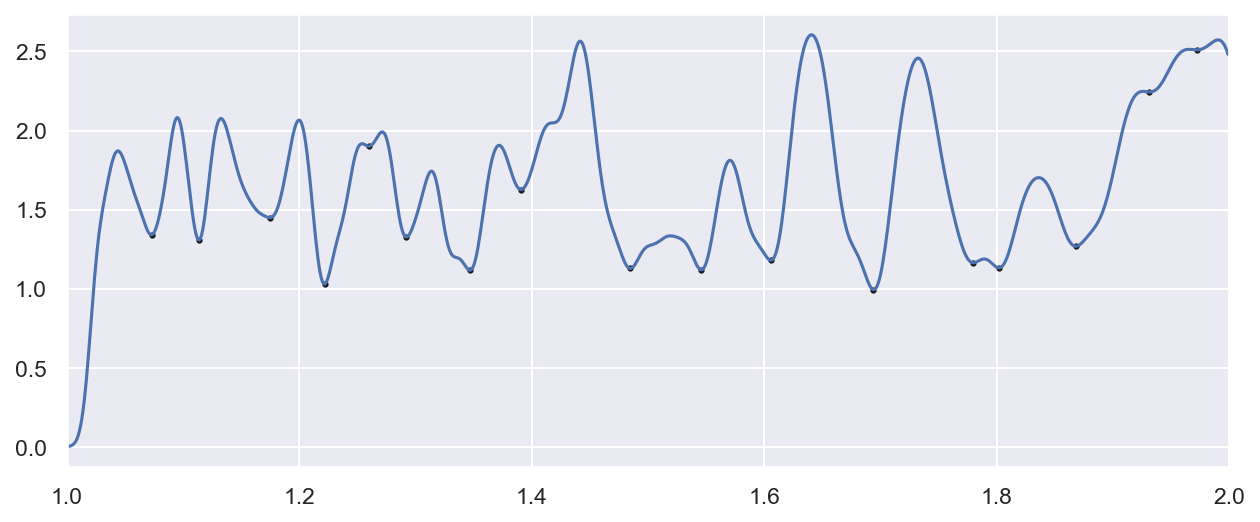

In [13]:
biotuning.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult',  n_harm = 30, 
                          cons_limit = 0.1, ratios_extension = True)
biotuning.compute_harmonic_entropy(input_type = 'extended_ratios_inc', plot_entropy = True, octave = 2, rebound = False, 
                                   scale_cons_limit = 0.01, sub=False)

In [14]:
print('Harmonic entropy metrics:', biotuning.scale_metrics)
print('Harmonic entropy tuning:', biotuning.HE_scale)
print('Harmonic entropy consonant tuning:', biotuning.HE_scale_cons)

Harmonic entropy metrics: {'diss_euler': 'NaN', 'dissonance': 0.5063975089495999, 'diss_harm_sim': 6.23562296784884, 'diss_n_steps': 8, 'HE': 1.6496422160027033, 'HE_n_steps': 17, 'HE_harm_sim': 0.9826557333978153}
Harmonic entropy tuning: [1.073 1.114 1.175 1.222 1.26  1.292 1.347 1.391 1.485 1.546 1.606 1.694
 1.78  1.802 1.868 1.931 1.972]
Harmonic entropy consonant tuning: [1.175 1.26  1.78 ]


In [15]:
### If you want the tuning in fraction
scale_frac, num, denom = scale2frac (biotuning.HE_scale, maxdenom = 100)
scale_frac

[103/96,
 88/79,
 47/40,
 11/9,
 63/50,
 115/89,
 66/49,
 121/87,
 49/33,
 150/97,
 53/33,
 144/85,
 89/50,
 173/96,
 99/53,
 56/29,
 140/71]

##  Deriving tunings from peaks ratios

In [16]:
biotuning.peaks_ratios  #peaks ratios

[1.0454545454545454,
 1.0892857142857142,
 1.2173913043478262,
 1.2727272727272727,
 1.326086956521739,
 1.375,
 1.3863636363636365,
 1.4375,
 1.75,
 1.90625]

extended peaks ratios with higher consonance levels

adjust the 'scale_cons_limit' value:

Comparisons with familiar ratios:
        
        #Unison-frequency ratio 1:1 yields a value of 2
        Octave-frequency ratio 2:1 yields a value of 1.5
        Perfect 5th-frequency ratio 3:2 yields a value of 0.833
        Perfect 4th-frequency ratio 4:3 yields a value of 0.583
        Major 6th-frequency ratio 5:3 yields a value of 0.533
        Major 3rd-frequency ratio 5:4 yields a value of 0.45
        Minor 3rd-frequency ratio 5:6 yields a value of 0.366
        Minor 6th-frequency ratio 5:8 yields a value of 0.325
        Major 2nd-frequency ratio 8:9 yields a value of 0.236
        Major 7th-frequency ratio 8:15 yields a value of 0.192
        Minor 7th-frequency ratio 9:16 yields a value of 0.174
        Minor 2nd-frequency ratio 15:16 yields a value of 0.129

In [19]:
biotuning.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult',  n_harm = 30, 
                          cons_limit = 0.1, ratios_extension = True, scale_cons_limit = 0.129) 
biotuning.extended_peaks_ratios_cons

array([1.273, 1.375, 1.444, 1.571, 1.7  , 2.   ])

## Plotting consonance matrix for a specific scale

#### The metric_function can be set to:
#### None : the denominator of the normalized ratio
#### dyad_similarity : similarity with the harmonic series
#### consonance : (a+b)/(a*b)

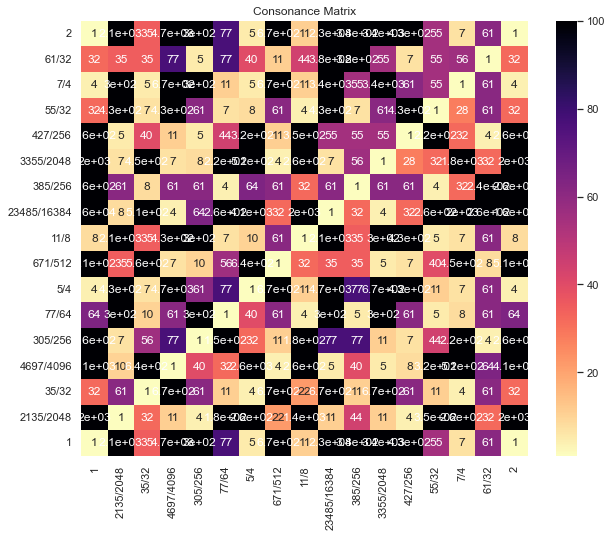

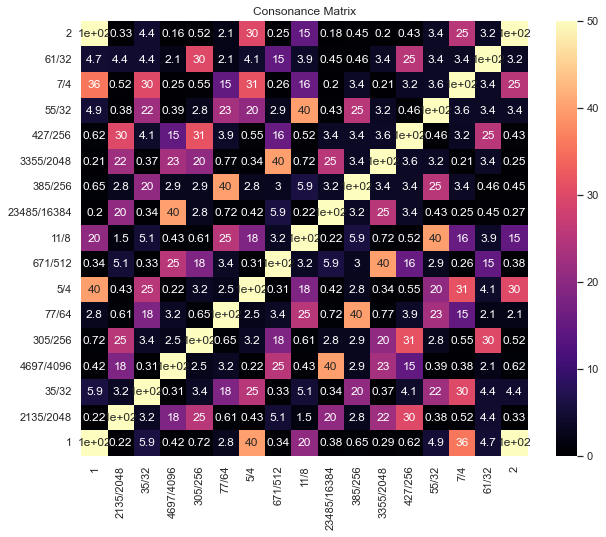

In [21]:
scale = biotuning.euler_fokker_scale(biotuning.peaks, octave = 2)
cons_matrix = consonance_matrix(scale, vmin = 1, vmax = 100, cmap = 'magma_r', fig = None)
cons_matrix_harmsim = consonance_matrix(scale, metric_function = dyad_similarity,
                                        vmin = 0, vmax = 50, cmap = 'magma', fig = None)

## Exporting scale in scala format

In [22]:
create_SCL(biotuning.HE_scale, 'Harmonic_entropy_scale')
create_SCL(biotuning.diss_scale, 'Dissonance_curve_scale')
create_SCL(biotuning.peaks_ratios, 'Peaks_ratios_scale')
create_SCL(biotuning.extended_peaks_ratios_cons, 'consonant_extended_peaks_ratios_scale')


## Computing scale metrics 

#### From peaks ratios

In [6]:
metrics_peaks = tuning_to_metrics(biotuning.peaks_ratios)
metrics_peaks

{'sum_p_q': 612,
 'sum_distinct_intervals': 58,
 'metric_3': 54.5107311890273,
 'sum_p_q_for_all_intervals': 40114,
 'sum_q_for_all_intervals': 18442,
 'harm_sim': 11.43,
 'matrix_harm_sim': 5.488430681018974,
 'matrix_cons': 0.057152855766348765,
 'matrix_denom': 234.55555555555554}

#### From dissonance curve tuning

In [12]:
metrics_peaks = tuning_to_metrics(biotuning.diss_scale)
metrics_peaks

{'sum_p_q': 1058,
 'sum_distinct_intervals': 56,
 'metric_3': 19.0665508064201,
 'sum_p_q_for_all_intervals': 324691,
 'sum_q_for_all_intervals': 134121,
 'harm_sim': 17.96,
 'matrix_harm_sim': 1.9379550103462375,
 'matrix_cons': 0.019685385723544918,
 'matrix_denom': 2129.714285714286}

## Spectromorphological computation

You can compute spectral chords based on the timepoint consonance levels between each Intrinsic Mode Functions (IMF). For each timepoint, the consonance is compute between the spectral centroid of each IMF.

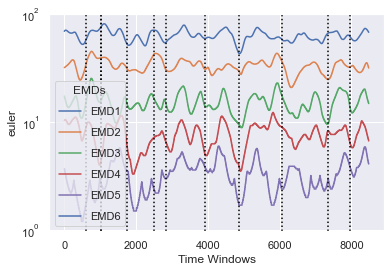

In [4]:
biotuning.compute_spectromorph(comp_chords = True, method = 'SpectralCentroid', min_notes = 4, cons_limit = 35, cons_chord_method = 'euler', 
                               window = 500, overlap = 1, graph = True)



In [5]:
biotuning.spectro_chords #correspond to moment in time when IMFs reach a level of consonance

[[1.6, 8.4, 14.0, 32.4, 56.0],
 [2.7, 4.4, 16.0, 39.6, 76.8],
 [2.7, 4.4, 16.0, 39.6, 77.0],
 [3.5, 6.6, 15.4, 32.0, 54.0],
 [2.4, 7.2, 16.5, 42.9, 71.5],
 [3.0, 6.6, 15.0, 30.8, 55.0],
 [4.0, 5.4, 14.7, 31.5, 60.0],
 [1.8, 4.0, 9.6, 30.0, 44.0],
 [2.4, 9.0, 17.5, 36.4, 58.5],
 [2.7, 8.0, 9.6, 25.0, 66.0],
 [4.0, 6.6, 14.4, 32.4, 63.0]]

#### You can also compute timepoint consonance between the instantaneous frequencies using the Hilbert-Huang transform.

Number of peaks:  5


(4000, 5)

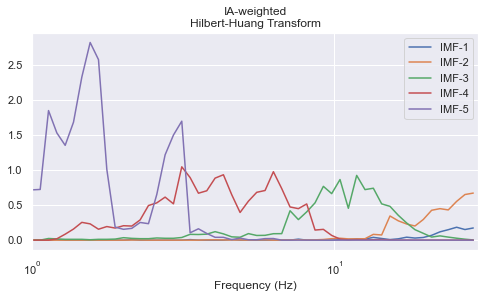

In [4]:
data_HH = data[46, 2000:6000]
bt_HH_chords = biotuner(sf = 1000, peaks_function = 'HH1D_max', precision = 0.5, n_harm = 20,
                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object

bt_HH_chords.peaks_extraction(data_HH, ratios_extension = True, max_freq = 30, n_peaks=5,
                          graph=True, min_harms=2)
bt_HH_chords.IF.shape

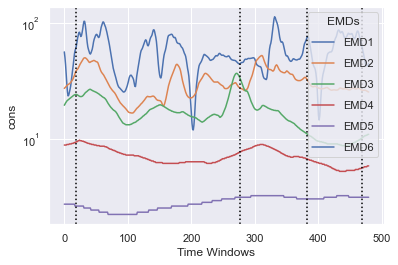

[[30.0, 2.7, 9.0], [7.2, 30.0, 3.0], [12.0, 3.0, 32.0], [5.4, 27.0, 9.3, 3.1]]

In [8]:
from biotuner.metrics import timepoint_consonance
data_IF = np.moveaxis(bt_HH_chords.IF[3000:3500, :], 0, 1)
chords, positions = timepoint_consonance(np.round(data_IF, 1), method='cons', limit=0.4, min_notes=3, graph=True)
chords

In [57]:
chords_ratios, chords_bounded = chords_to_ratios(chords, harm_limit = 2, spread = False)
chords_ratios

[[27, 38, 45], [15, 18, 19], [3, 4, 6], [31, 34, 46, 54]]

In [58]:
chords_ratios2, chords_bounded2 = chords_to_ratios(chords, harm_limit = 2, spread = True)
chords_ratios2

[[9, 15, 25], [15, 18, 19], [3, 6, 8], [31, 54, 93, 135]]

## Classical tuning creation from peaks and extended peaks

In [10]:
#Initiate object and extract peak information
biotuning_class_scales = biotuner(sf = 1000, peaks_function = 'EMD', precision = 0.1, n_harm = 15,
                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object

biotuning_class_scales.peaks_extraction(data_, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 50)

Number of peaks:  5


### Euler-Fokker Genera using peaks as generators (using method)

In [11]:
biotuning_class_scales.euler_fokker_scale(biotuning.peaks)

[1,
 2135/2048,
 35/32,
 4697/4096,
 305/256,
 77/64,
 5/4,
 671/512,
 11/8,
 23485/16384,
 385/256,
 3355/2048,
 427/256,
 55/32,
 7/4,
 61/32,
 2]

### Euler-Fokker Genera using extended peaks as generators (using function)

In [30]:
biotuning_class_scales.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult', 
                                       div_mode = 'div_add', n_harm = 22, 
                          cons_limit = 0.13, ratios_extension = True)
euler_fokker_scale(biotuning_class_scales.extended_peaks)

Number of extended peaks :  3


[1,
 17135/16384,
 17/16,
 291295/262144,
 149/128,
 2533/2048,
 115/64,
 1955/1024,
 2]

In [40]:
biotuning_class_scales.peaks_extension(method = 'consonant_harmonic_fit', harm_function = 'mult', n_harm = 28, 
                          cons_limit = 0.1, ratios_extension = True)
EFG_scale = biotuning_class_scales.euler_fokker_scale(biotuning_class_scales.extended_peaks)
scale_interval_names(EFG_scale, reduce = False)

Number of extended peaks :  6


[[1, 'Unison'],
 [33525/32768, None],
 [67275/65536, None],
 [4369425/4194304, None],
 [8768175/8388608, None],
 [17135/16384, None],
 [34385/32768, None],
 [17/16, 'Minor Diatonic Semitone'],
 [1152757125/1073741824, None],
 [569925/524288, None],
 [1143675/1048576, None],
 [2235/2048, None],
 [4485/4096, None],
 [291295/262144, None],
 [584545/524288, None],
 [19596871125/17179869184, None],
 [76850475/67108864, None],
 [37995/32768, None],
 [76245/65536, None],
 [149/128, None],
 [299/256, 'Two-hundred-ninety-ninth Harmonic'],
 [10023975/8388608, None],
 [1306458075/1073741824, None],
 [5123365/4194304, None],
 [2533/2048, None],
 [5083/4096, None],
 [170407575/134217728, None],
 [668265/524288, None],
 [87097205/67108864, None],
 [11360505/8388608, None],
 [44551/32768, None],
 [757367/524288, None],
 [25875/16384, None],
 [439875/262144, None],
 [1725/1024, None],
 [225/128, 'Just Augmented Sixth II'],
 [29325/16384, None],
 [115/64, 'Hundred-fifteenth Harmonic'],
 [3855375/209715

### Harmonic scale using the positions of congruent harmonics



##### Using the harmonic positions derived from the peak extraction method 'harmonics peaks'
This method computes all peaks of the spectrum, and keeps peaks for which a maximum of other peaks are harmonics. This method gives as an ouput the peaks and the positions of congruent harmonics. The *max_freq* argument determines the maximum frequency that can be choose as a peak. The *min_harms* argument indicates the minimum number of congruent harmonics to keep the peak. 

In [7]:
biotuning_harm_peaks = biotuner(sf = 1000, peaks_function = 'harmonic_peaks', precision = 0.5) # Initialize biotuner object

biotuning_harm_peaks.peaks_extraction(data_, max_freq = 50, min_harms = 2, harm_limit = 128)
print(biotuning_harm_peaks.all_harmonics)

biotuning_harm_peaks.peaks_extraction(data_, max_freq = 50, min_harms = 9, harm_limit = 128)
print(biotuning_harm_peaks.all_harmonics)

Number of peaks:  10
[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 20. 23.
 24. 27. 36. 41. 45. 47. 51. 56. 68. 72. 84. 90. 97.]
Number of peaks:  2
[ 2.  7.  9. 10. 13. 14. 15. 16. 17. 20. 24. 27. 36. 41. 45. 51. 56.]


Harmonic scales are constructed by transforming a series of harmonic positions into ratios falling between the unison (1) and the octave (2). For example, using the harmonics 3, 5 and 7 would yields a scale of 1, 1.5, 1.25 and 1.75, since 3/2=1.5, 5/2^2 = 1.25 and 7/2^2 = 1.75

In [6]:
harm_tuning = harmonic_tuning(biotuning_harm_peaks.all_harmonics)
harm_tuning

[1.0625,
 1.125,
 1.25,
 1.28125,
 1.40625,
 1.5,
 1.59375,
 1.625,
 1.6875,
 1.75,
 1.875,
 2.0]

Instead of using all the harmonics, we can use the peak that has the most harmonics as other peaks to generate a tuning

In [44]:
harmonics = [abs(h) for h in biotuning_harm_peaks.harmonics[0]] #converts the subharmonics (negative values) 
                                                                #into harmonics (positive values)
harm_peak_tuning = harmonic_tuning(harmonics)
harmonics, harm_peak_tuning

([16.0, 10.0, 14.0, 16.0, 24.0, 41.0, 45.0, 51.0, 56.0],
 [1.25, 1.28125, 1.40625, 1.5, 1.59375, 1.75, 2.0])

In [46]:
metrics = tuning_to_metrics(harm_peak_tuning)
metrics

{'sum_p_q': 261,
 'sum_distinct_intervals': 42,
 'metric_3': 16.0346378767431,
 'sum_p_q_for_all_intervals': 2501,
 'sum_q_for_all_intervals': 1032,
 'harm_sim': 36.88,
 'matrix_harm_sim': 14.417357051221572,
 'matrix_cons': 0.15571661252576913,
 'matrix_denom': 26.761904761904763}

##### Using the harmonic position of the congruent harmonics of peaks

In [11]:
harm_tuning2 = biotuning.harmonic_fit_tuning(n_harm =128, bounds = 0.1, n_common_harms = 20)
harm_tuning2


[1.03125,
 1.078125,
 1.25,
 1.375,
 1.4375,
 1.5,
 1.71875,
 1.75,
 1.796875,
 1.90625,
 2.0]

In [49]:
metrics = tuning_to_metrics(harm_tuning2)
metrics

{'sum_p_q': 643,
 'sum_distinct_intervals': 86,
 'metric_3': 61.8353688701868,
 'sum_p_q_for_all_intervals': 8945,
 'sum_q_for_all_intervals': 3694,
 'harm_sim': 26.75,
 'matrix_harm_sim': 13.433908683758839,
 'matrix_cons': 0.14675197712609425,
 'matrix_denom': 36.945454545454545}

##### Scale from generator interval

In [50]:
data_gen = data[30] # Define data (single time series)


#biotuning = biotuner(sf = 1000, peaks_function = 'EEMD', precision = 0.1, n_harm = 10,
#                    ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object

biotuning.peaks_extraction(data_gen, FREQ_BANDS = FREQ_BANDS, ratios_extension = True, max_freq = 50)

ratios, cons = consonant_ratios(biotuning.peaks, limit = 0.01, input_type = 'peaks', metric = 'harmsim') #finding the intervals
ratio_arg = np.argmax(cons)
cons_ratio = ratios[ratio_arg]

Number of peaks:  5


In [51]:
gen_interval_tuning = pytuning.scales.create_equal_interval_scale(ratios[0], scale_size = 11, number_down_intervals = 6, octave = 2)
gen_interval_tuning = [float(x) for x in gen_interval_tuning]

frac, _, _ = scale2frac(gen_interval_tuning, 64) # Transform the ratios into fractions with controlled maximum denominator.
                                                 # Using smaller denominator limit will maximize the chance to find intervalic names in the dictionary
frac2, _, _ = scale2frac(gen_interval_tuning, 16)

print(scale_interval_names(frac, reduce = False),'\n\n', scale_interval_names(frac2, reduce = False))

[[1, 'Unison'], [25/24, 'Just Chromatic Semitone'], [38/35, None], [43/38, None], [33/28, None], [25/16, 'Just Augmented Fifth'], [70/43, None], [95/56, None], [99/56, None], [35/19, None], [119/62, None], [2, 'Octave']] 

 [[1, 'Unison'], [17/16, 'Minor Diatonic Semitone'], [13/12, 'Greater Tridecimal 2/3-tone'], [17/15, None], [13/11, None], [25/16, 'Just Augmented Fifth'], [13/8, 'Tridecimal Neutral Sixth'], [17/10, None], [23/13, None], [24/13, None], [23/12, None], [2, 'Octave']]


In [52]:
gen_interval_tuning = [np.round(float(t), 3) for t in gen_interval_tuning]
metrics = tuning_to_metrics(gen_interval_tuning)
metrics

{'sum_p_q': 16982,
 'sum_distinct_intervals': 110,
 'metric_3': 58.0387576742509,
 'sum_p_q_for_all_intervals': 251067,
 'sum_q_for_all_intervals': 103732,
 'harm_sim': 16.99,
 'matrix_harm_sim': 2.887453893214587,
 'matrix_cons': 0.038980667431423525,
 'matrix_denom': 889.469696969697}

##### Scale reduction based on harmonicity between ratios

In [53]:
tuning_metric, reducted_tuning, mode_metric = tuning_reduction(biotuning.peaks_ratios, mode_n_steps = 6, 
                                                            function = dyad_similarity, ratio_type='pos_harm')
tuning_metric, np.sort(reducted_tuning), mode_metric

(11.396107835726882,
 array([1.0714, 1.25  , 1.35  , 1.6667, 1.6875, 1.7857]),
 14.634406387281839)

## Visualizing ratios with Lissajous curves

#### thanks to https://glowingpython.blogspot.com/2011/12/lissajous-curves.html

[25/24, 15/14, 7/6, 5/4, 27/20, 81/56, 81/50, 5/3, 27/16, 25/14]


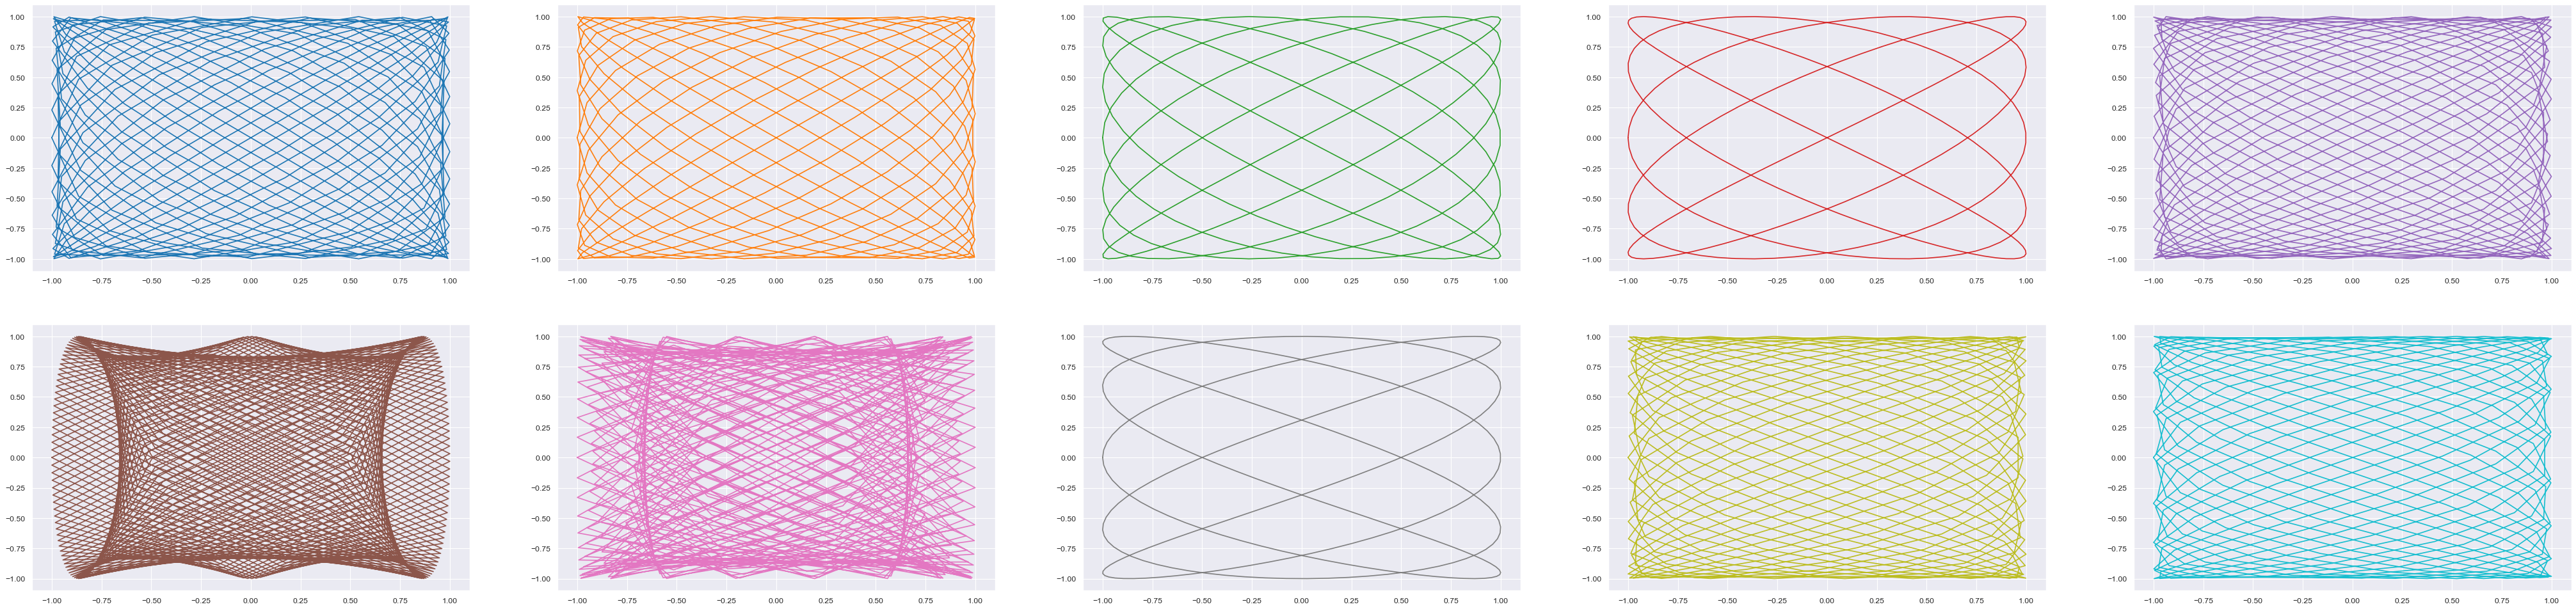

In [54]:
from biotuner.vizs import lissajous_curves
tuning = biotuning.harmonic_fit_tuning()
tuning = biotuning.peaks_ratios
lissajous_curves(tuning)

[1, 521/500, 543/500, 1131/1000, 1179/1000, 1563/1000, 407/250, 1697/1000, 221/125, 921/500, 1919/1000, 2]


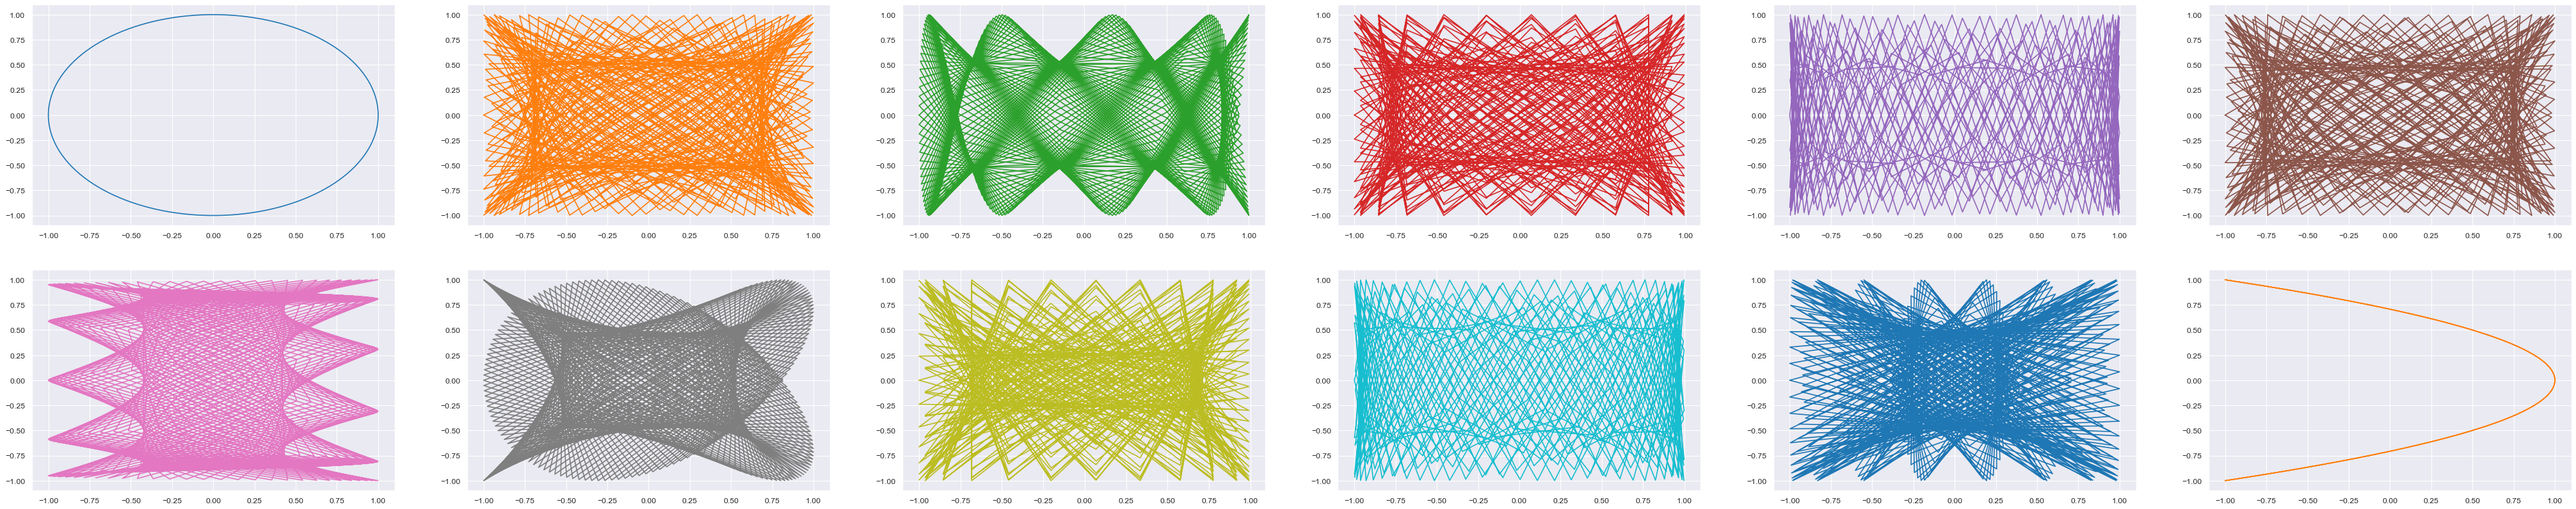

In [55]:
lissajous_curves(gen_interval_tuning)

##### Congruent N-TET derived from multiple ratios

## Constructing euclidian rhythms from biotunings

Euclidian rhythms represent an even distribution of pulses within a specified number of steps. It is possible to convert frequency ratios into euclidian rhythms in that a ratio's numerator can be seen as the number of pulses and a ratio's denominator as the number of steps within which the pulses should be distributed. 

In [8]:
cons_harm_tuning = sort_scale_by_consonance(harm_tuning) # sorting a tuning by consonance of intervals
cons_harm_tuning

[2.0,
 1.5,
 1.25,
 1.75,
 1.125,
 1.625,
 1.875,
 1.0625,
 1.6875,
 1.28125,
 1.40625,
 1.59375]

'scale2euclid' function derives euclidian rhythms from a series of ratios.

When mode = 'normal', the ratios are inverted and the numerator is taken as the number of pulses and the denominator as the number of steps (e.g. 3/2 -> 2pulses/3steps).

When mode = 'full', the ratios are inverted. The number of steps corresponds to num*denom and the numbers of pulses correspond to both the initial numerator and denominator (e.g. 3/2 -> 3pulses/6steps and 2pulses/6steps)

In [9]:
euclid_patterns = scale2euclid(cons_harm_tuning[2:8], max_denom = 16, mode = 'normal')
harm_tuning_frac, _, _ = scale2frac(cons_harm_tuning[2:8])
interval_vectors = [interval_vector(x) for x in euclid_patterns]
harm_tuning_frac, euclid_patterns, interval_vectors

([5/4, 7/4, 9/8, 13/8, 15/8, 17/16],
 [[1, 1, 1, 1, 0],
  [1, 0, 1, 0, 1, 0, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 0],
  [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
  [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]],
 [[1, 1, 1, 2],
  [2, 2, 2, 1],
  [1, 1, 1, 1, 1, 1, 1, 2],
  [2, 1, 2, 2, 1, 2, 2, 1],
  [2, 2, 2, 2, 2, 2, 2, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]])

'consonant_euclid' function derives euclidian rhythm from a set of consonant intervals. 

First, a set of denominators is defined by finding the common denominator of each pair of ratios (e.g. 3/5 and 4/7 give 5*7=35). 

The consonance is computed on each pairs of denominators to find harmonic subdivisions. Only the euclidian rhythms from consonant denominators (steps) are returned.

In [12]:
euclid_final, cons = consonant_euclid(harm_tuning2, n_steps_down = 2, limit_denom = 8, 
                                      limit_cons = 0.1, limit_denom_final = 16)
interval_vectors = [interval_vector(x) for x in euclid_final]
strings = interval_vec_to_string(interval_vectors)
euclid_referent = euclid_string_to_referent(strings, dict_rhythms)
euclid_final, interval_vectors, euclid_referent

C:\Users\Dell\Anaconda3\envs\biotuner\lib\fractions.py:597: RuntimeWarning: overflow encountered in longlong_scalars
  self._denominator * other.numerator)


([[1, 0],
  [1, 0, 0],
  [1, 0, 0, 0],
  [1, 0, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 1, 0, 0],
  [1, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
  [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
  [1, 0, 1, 0, 1, 0],
  [1, 0, 1, 0, 1, 0, 0],
  [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0],
  [1, 0, 1, 0, 1, 0, 1, 0],
  [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
  [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
  [1, 0, 1, 1, 0, 1, 1, 0],
  [1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0],
  [1, 1, 1, 1, 1, 1, 0],
  [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]],
 [[2],
  [3],
  [4],
  [4, 4],
  [4, 4, 4],
  [3, 3],
  [3, 4],
  [3, 4, 3, 4],
  [3, 3, 3, 3],
  [2, 2, 2],
  [2, 2, 3],
  [2, 2, 3, 2, 2, 3],
  [2, 2, 2, 2],
  [2, 2, 2, 2, 2, 2, 2],
  [2, 2, 2, 2, 2, 2, 2, 2],
  [2, 1, 2, 1, 2],
  [2, 1, 2, 1, 2, 2, 1, 2, 1, 2],
  [1, 1, 1, 1, 1, 2],
  [1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2]],
 ['None',
  'None',
  'None',
  'None',
  'None',
  'None',


In [13]:
interval_vector(bjorklund(16, 13))

[1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1]

### Listening to scales and chords

In [23]:
listen_scale(biotuning.diss_scale, 250, 500)

Scale: [1.127906976744186, 1.178082191780822, 1.216867469879518, 1.2717391304347827, 1.3770491803278688, 1.4339622641509433, 1.5, 1.5714285714285714, 1.6419753086419753, 1.7849462365591398, 1.9148936170212767, 2.0]
250
281.9767441860465
294.52054794520546
304.2168674698795
317.9347826086957
344.2622950819672
358.49056603773585
375.0
392.85714285714283
410.4938271604938
446.23655913978496
478.72340425531917
500.0


In [81]:
listen_chords(chords_bounded[:], 200, 500)

Chords: [[1.0, 1.0, 1.1153846153846154, 1.1153846153846154], [1.0, 1.0833333333333333, 1.25, 1.75], [1.0, 1.1111111111111112, 1.3703703703703705, 1.5185185185185186], [1.0, 1.5, 1.5789473684210527, 1.736842105263158], [1.0, 1.0625, 1.375, 1.9375], [1.0, 1.2105263157894737, 1.263157894736842, 1.4210526315789473], [1.0, 1.1320754716981132, 1.3396226415094339, 1.5660377358490567]]


In [82]:
listen_chords(chords_bounded2[:], 200, 500)

Chords: [[1.0, 1.0, 1.1153846153846154, 1.1153846153846154], [1.0, 1.75, 2.1666666666666665, 2.5], [1.0, 1.1111111111111112, 1.3703703703703705, 1.5185185185185186], [1.0, 1.5, 1.736842105263158, 3.1578947368421053], [1.0, 1.375, 2.1875, 3.8125], [1.0, 1.2105263157894737, 1.263157894736842, 1.4210526315789473], [1.0, 1.5660377358490567, 2.2641509433962264, 2.6792452830188678]]


## Multiple dissonance curves

A succession of time windows can be used to compute multiple dissonance curves. The function *diss_curve_multi* takes a list of list of frequency peaks and amplitudes and gives as output the dissonant minima that are shared by minimally 2 dissonance curves. Here we iterate across *n* channels to generate multiple dissonance curves

In [4]:
data_ = np.load('data_examples/EEG_pareidolia/parei_data_1000ts.npy')
#data.shape

Number of peaks:  5
Number of extended peaks :  7
Number of peaks:  5
Number of extended peaks :  6
Number of peaks:  5
Number of extended peaks :  14
Number of peaks:  5
Number of extended peaks :  17
Number of peaks:  5
Number of extended peaks :  15
7/6
6/5
6/5
5/4
5/4
4/3
4/3
7/5
3/2
8/5
5/3
5/3
7/4
174/95


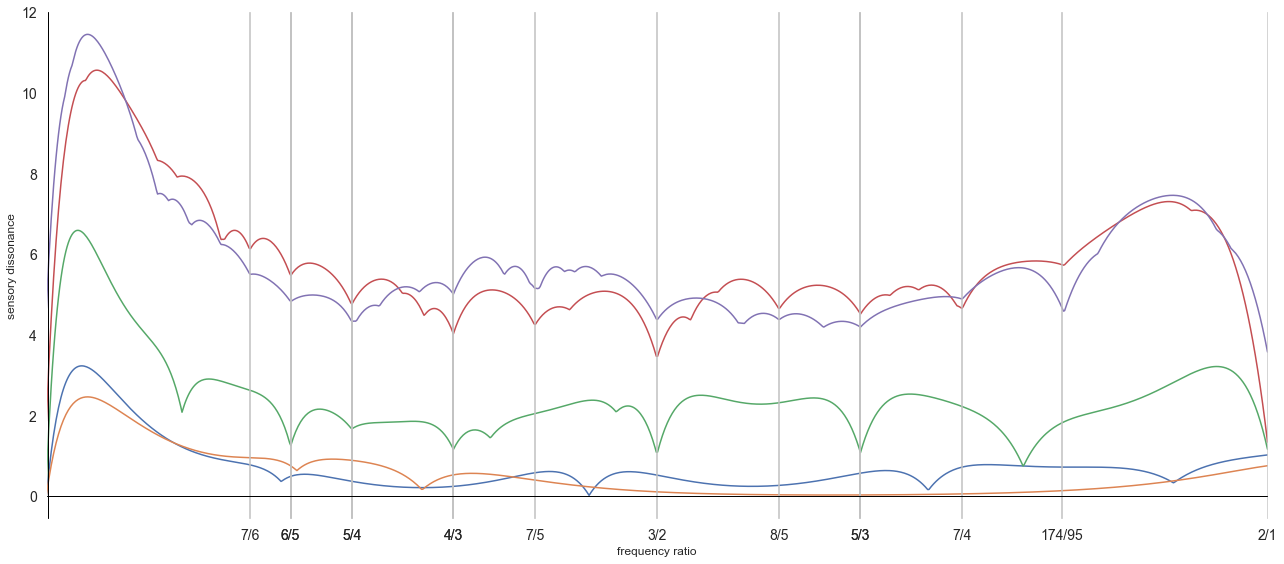

In [15]:
from biotuner.biotuner2d import diss_curve_multi
n_harm = 15
peaks_tot = []
amps_tot = []
for d in range(5):
    d +=0
    data = data_[d]
    diss_tun = biotuner(sf = 1000, peaks_function = 'EMD', precision = 0.5,
                        ratios_n_harms = 5, ratios_inc_fit = True, ratios_inc = True) # Initialize biotuner object
    diss_tun.peaks_extraction(data, ratios_extension = True, max_freq = 50)
    _ = diss_tun.peaks_extension(method = 'harmonic_fit', n_harm = n_harm)
    peaks_tot.append(diss_tun.extended_peaks)
    amps_tot.append(diss_tun.extended_amps)

diss_tot = diss_curve_multi(peaks_tot, amps_tot, denom=100, max_ratio=2, bound=0.5)
#biotuning.psd.shape

### MOS scales

In [16]:
mediant, mediant_frac, gen_interval, gen_interval_frac, MOS_sig, invert_MOS_sig = tuning_range_to_MOS(5/7, 9/29,
                                                                                                    max_denom_out = 64)
mediant_frac, gen_interval_frac, MOS_sig

5 7 9 29


(7/18, 55/42, [29, 7])